# Univariate regression to predict the wind speed field

In [1]:
import torch
import torch.nn as nn
import numpy as np

from utils.metrics import MetricsLogger
from utils.data_loaders import get_wake_dataloaders
import utils.utils as uutils
import utils.data_utils as data_utils
import utils.plotting as plotting
from utils.evaluation import test_pytorch_model

# define random seeds for Neural Networks
torch.manual_seed(0)
np.random.seed(0)

In [2]:
HIDDEN_LAYERS_UNITS = [50, 250]
ACTIVATION_FUNCTION = nn.Sigmoid()

class UnivariateNN(nn.Module):
    def __init__(self, input_space, output_space) -> None:
        super(UnivariateNN, self).__init__()
        layer_units = [input_space] + HIDDEN_LAYERS_UNITS + [output_space]
        layers = list()
        for first, second in zip(layer_units, layer_units[1:]):
            layers += [nn.Linear(first, second), ACTIVATION_FUNCTION]
        self.layers = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.layers(x)

In [3]:
FACTORS_FOLDER = "discr_factors_x2_30_y-2_2_step0.125_TIstep0.01_CTstep0.01"
DATA_FOLDER = f"data/{FACTORS_FOLDER}/"
MODEL_NAME = f"univariate_NN_layers{'-'.join(str(lu) for lu in HIDDEN_LAYERS_UNITS)}"
BEST_MODEL_PATH = f"saved_models/{FACTORS_FOLDER}/{MODEL_NAME}.pt"
CONSIDER_WS = False
COORDS_AS_INPUT = True # univariate setting
if CONSIDER_WS:
    MODEL_NAME += "_consider_ws"
    BEST_MODEL_PATH = f"saved_models/{FACTORS_FOLDER}/{MODEL_NAME}.pt"\
        .replace("TIstep0.01_CTstep0.01", "reducedTI-CT")
    print(MODEL_NAME)
    print(BEST_MODEL_PATH)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"{DEVICE=}")

# hyperparameters
# in univariate, the batch size is a multiplier for number of cells
# (i.e. the batch_size should be dividible by the number of cells)
BATCH_MULTIPLIER = 1
EPOCHS = 500
LR = 0.00001

DEVICE=device(type='cpu')


In [4]:
valid_dataloader = None
train_dataloader, valid_dataloader, test_dataloader = get_wake_dataloaders(DATA_FOLDER,
                                                          consider_ws=CONSIDER_WS,
                                                          coords_as_input=COORDS_AS_INPUT,
                                                          train_perc=0.6,
                                                          test_perc=0.2,
                                                          validation_perc=0.2,
                                                          batch_multiplier=BATCH_MULTIPLIER)
len(train_dataloader)

5160

In [5]:
for b in train_dataloader:
    print(b[0].shape, b[1].shape)
    break

input_space = train_dataloader.dataset.inputs.shape[1]
output_space = train_dataloader.dataset.outputs.shape[1]
print(f"{input_space=}\t{output_space=}")

torch.Size([7168, 4]) torch.Size([7168, 1])
input_space=4	output_space=1


In [6]:
model = UnivariateNN(input_space, output_space).to(DEVICE)

optimizer = torch.optim.Adam(
    (p for p in model.parameters() if p.requires_grad), lr=LR
)
loss_function = torch.nn.MSELoss()

metrics_logger = MetricsLogger(name=MODEL_NAME)
best_vloss = 1_000_000.
for epoch in range(EPOCHS):
    '''TRAINING'''
    model.train(True)
    epoch_tloss = 0
    for batch in iter(train_dataloader):
        x, y = batch[0].to(DEVICE), batch[1].to(DEVICE)
        optimizer.zero_grad()
        prediction = model(x)
        tloss = loss_function(prediction, y)
        tloss.backward()
        #torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5) TODO
        optimizer.step()

        epoch_tloss += tloss.item() * x.size(0)
        #TODO accuracy or other metric computation????

    avg_tloss = epoch_tloss / len(train_dataloader.sampler)
    metrics_logger.log_metric(epoch, 'Training loss', avg_tloss)

    '''VALIDATION'''
    if valid_dataloader:
        model.train(False)
        epoch_vloss = 0
        for batch in iter(valid_dataloader):
            x, y = batch[0].to(DEVICE), batch[1].to(DEVICE)
            prediction = model(x)
            vloss = loss_function(prediction, y)

            epoch_vloss += vloss.item() * x.size(0)

        avg_vloss = epoch_vloss / len(valid_dataloader.sampler)
        metrics_logger.log_metric(epoch, 'Validation loss', avg_vloss)
        # Track best performance, and save the model's state
        if avg_vloss < best_vloss:
            best_vloss = avg_vloss
            torch.save(model.state_dict(), BEST_MODEL_PATH)


metrics_logger.plot_metrics_by_epoch()
metrics_logger.save_metrics()

Logging univariate_NN_layers50-250
Epoch 0 ->	Training loss=0.03328770034235375	Validation loss=0.0017891158501084266	
Epoch 1 ->	Training loss=0.001232118558841613	Validation loss=0.0011349317198416197	
Epoch 2 ->	Training loss=0.0010938605637914075	Validation loss=0.0011241929333770057	
Epoch 3 ->	Training loss=0.0010717325330492607	Validation loss=0.0010827823109477407	
Epoch 4 ->	Training loss=0.0009909484243853372	Validation loss=0.0009514310688669062	
Epoch 5 ->	Training loss=0.0008541432375362677	Validation loss=0.0008415093990167808	
Epoch 6 ->	Training loss=0.0008011112728380858	Validation loss=0.0008268203578884209	
Epoch 7 ->	Training loss=0.0007964595390980984	Validation loss=0.0008261837433205665	
Epoch 8 ->	Training loss=0.0007960460067306133	Validation loss=0.0008258662985711422	
Epoch 9 ->	Training loss=0.0007957174833354093	Validation loss=0.0008253638563725111	
Epoch 10 ->	Training loss=0.0007953609336508698	Validation loss=0.0008250845660541017	
Epoch 11 ->	Training 

KeyboardInterrupt: 

# Testing

In [6]:
# loading best model
model = UnivariateNN(input_space, output_space).to(DEVICE)
model.load_state_dict(torch.load(BEST_MODEL_PATH))
model.eval()
test_pytorch_model(model, test_dataloader,
                   model_description=f"{MODEL_NAME}_{FACTORS_FOLDER} (act. func. {ACTIVATION_FUNCTION.__class__.__name__})",
                   save_results=True)

Test results
r2_score=0.3385892630881038
explained_variance_score=0.33872485160827637
mean_squared_error=0.000763433868996799
mean_absolute_error=0.012067914009094238
median_absolute_error=0.0038194761145859957
mean_absolute_percentage_error=427304517632.0


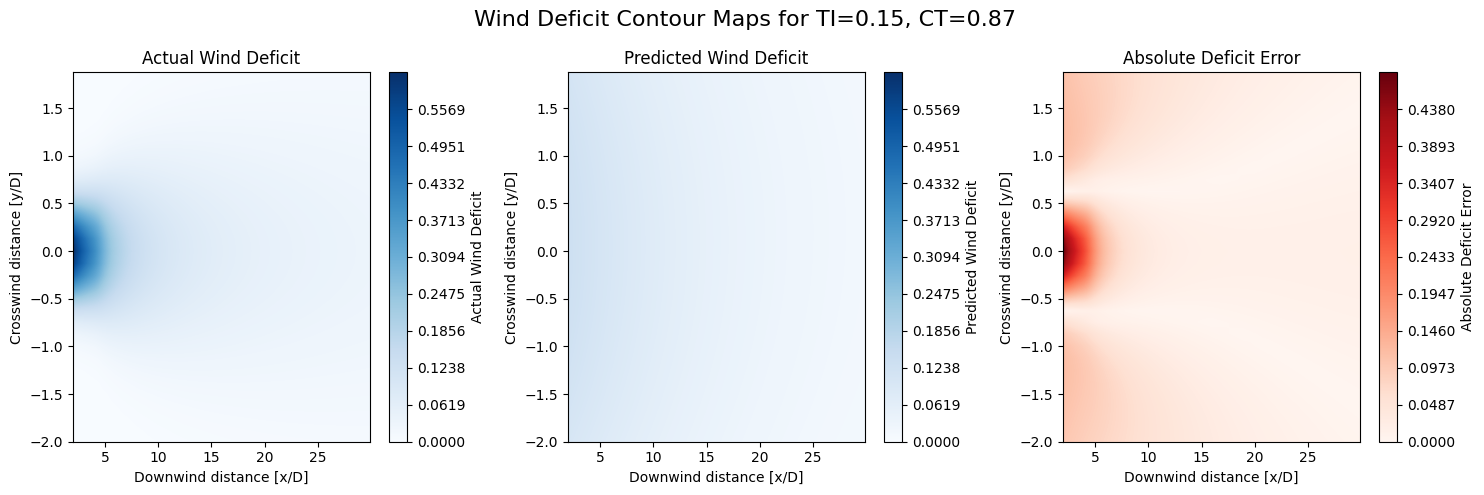

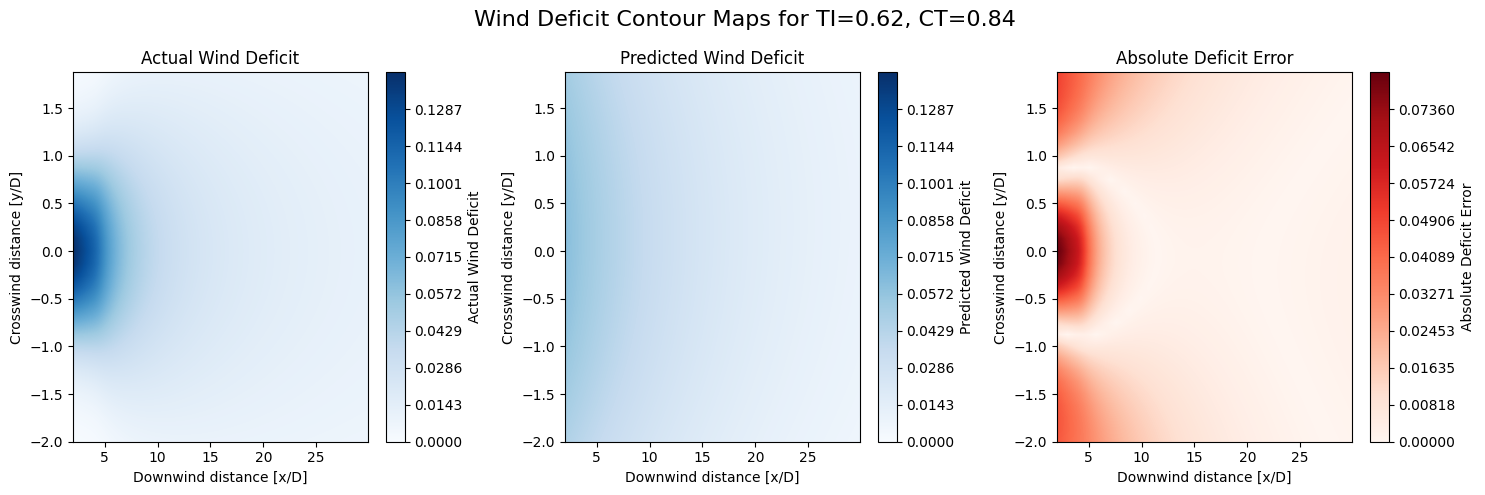

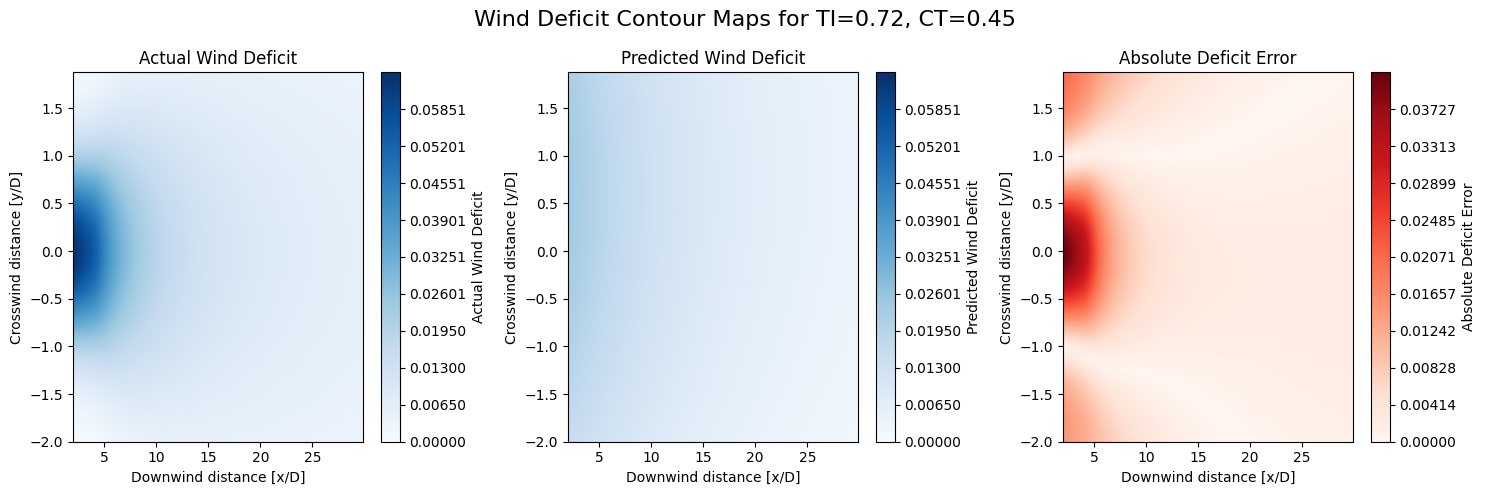

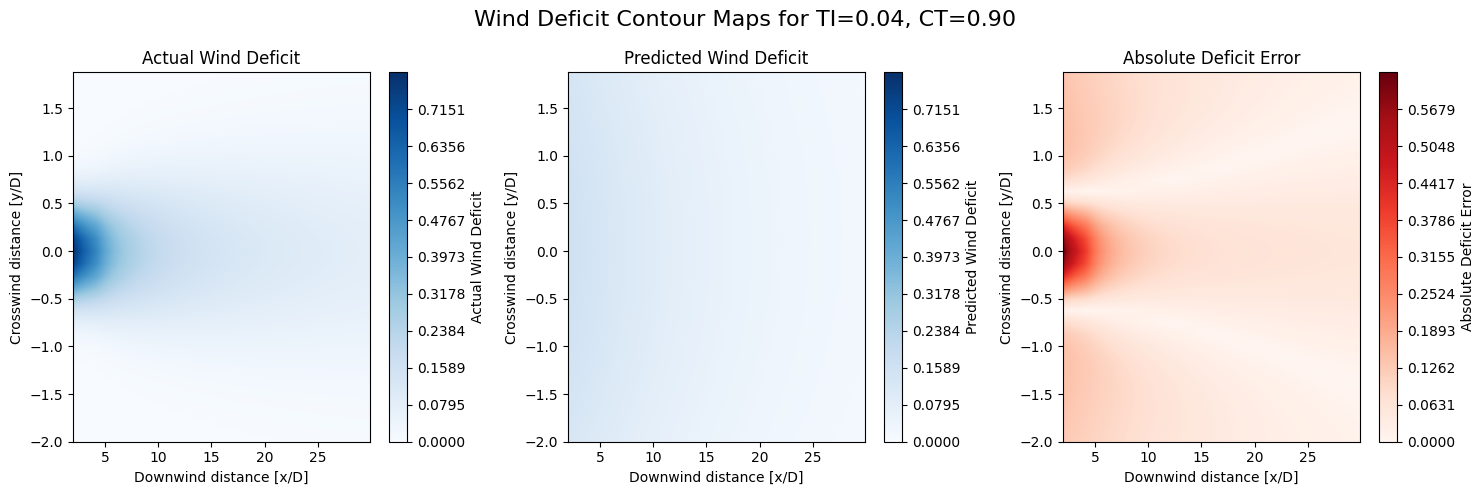

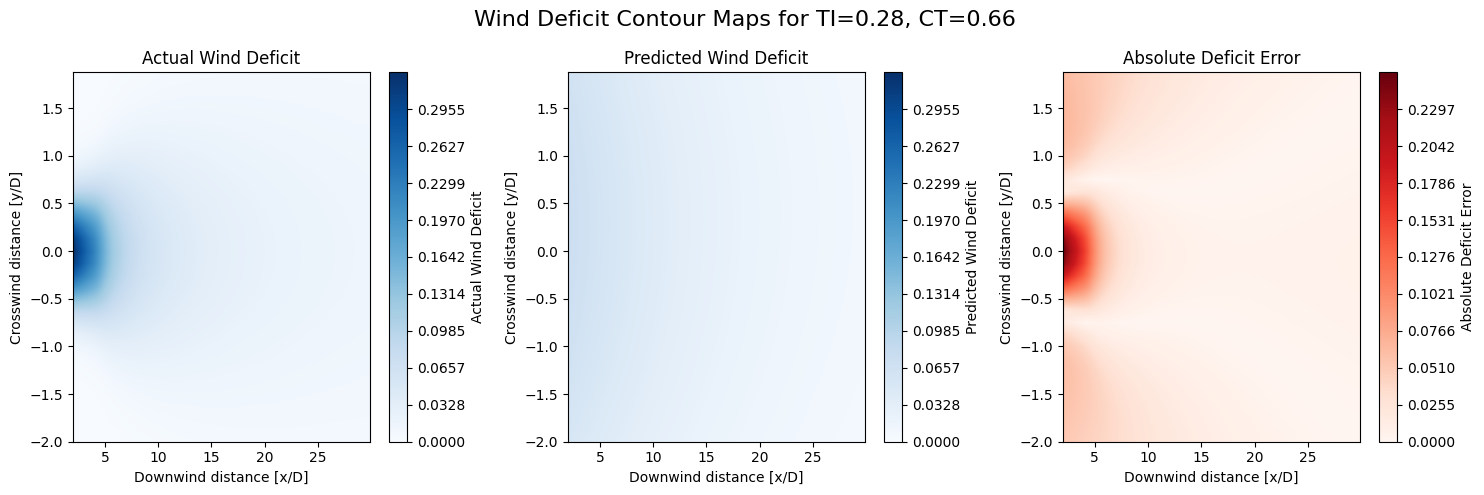

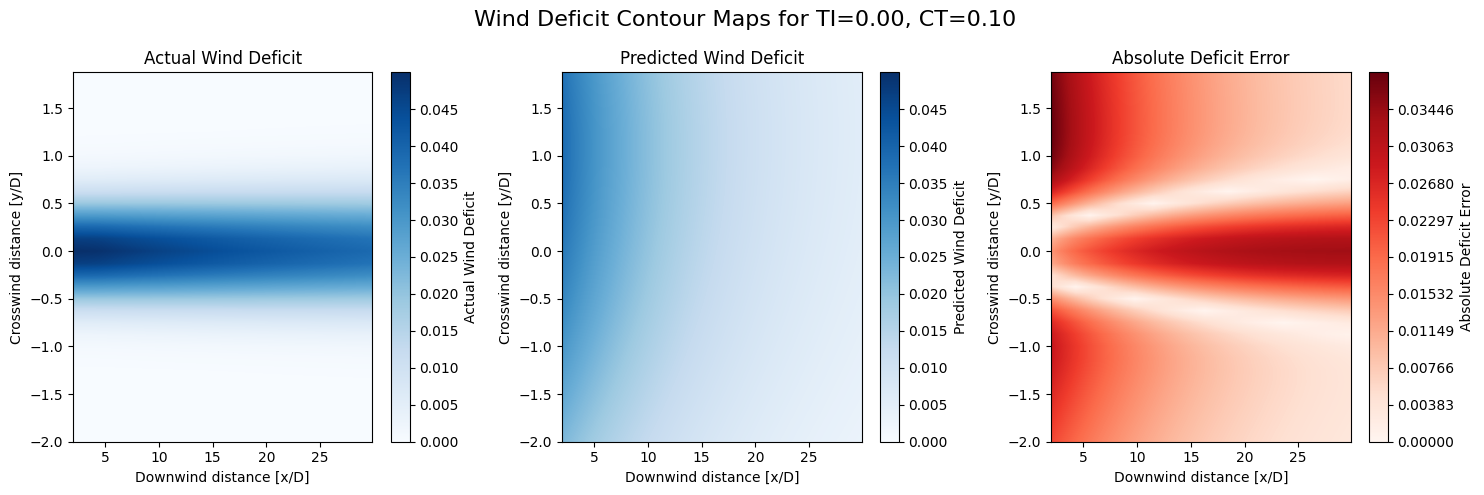

KeyboardInterrupt: 

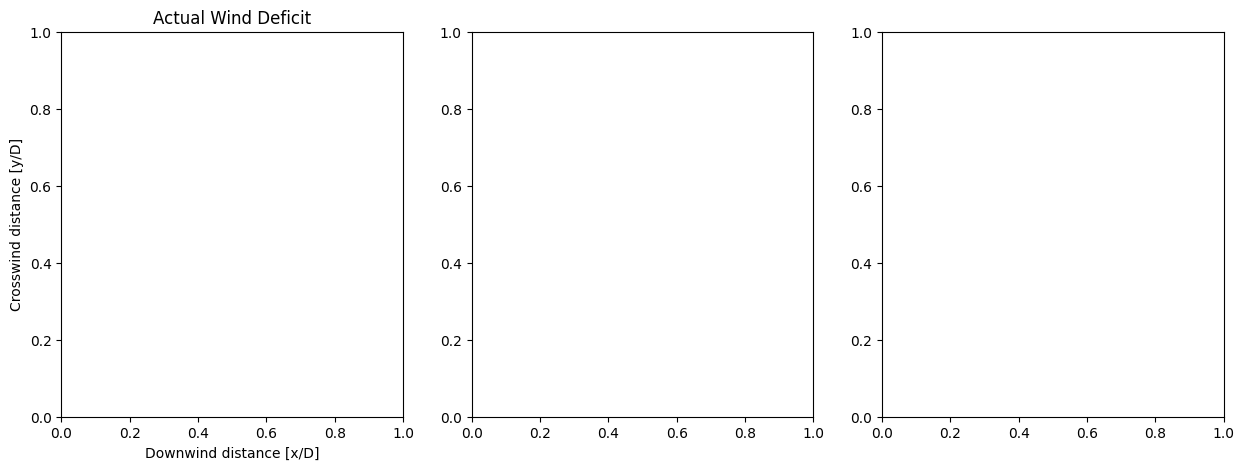

In [9]:
test_dataset = test_dataloader.dataset
num_cells = test_dataset.num_cells
num_fields = int(len(test_dataloader)/BATCH_MULTIPLIER)

with torch.no_grad():
    for field_idx in range(num_fields):
        ti, ct, ws, wake_field, predicted_wake_field = test_dataset.get_parameters_for_plotting_univariate(model, field_idx)
        plotting.plot_maps(test_dataset.X_grid, test_dataset.Y_grid, wake_field, predicted_wake_field, ti, ct, ws, error_to_plot='absolute')